In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import sort
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,StandardScaler,OrdinalEncoder,PolynomialFeatures
from sklearn.model_selection import cross_val_score, cross_val_predict,RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.ensemble import  RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score,confusion_matrix
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier
from imblearn.over_sampling import ADASYN

In [2]:
train = pd.read_csv('train.csv')
train.head()

,EmployeeNo,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,Promoted_or_Not
0,YAK/S/00001,Commercial Sales and Marketing,"MSc, MBA and PhD",Female,Direct Internal process,2,1986,12.5,2011,1,0,41,ANAMBRA,No,Married,No,No,0,0
1,YAK/S/00002,Customer Support and Field Operations,First Degree or HND,Male,Agency and others,2,1991,12.5,2015,0,0,52,ANAMBRA,Yes,Married,No,No,0,0
2,YAK/S/00003,Commercial Sales and Marketing,First Degree or HND,Male,Direct Internal process,2,1987,7.5,2012,0,0,42,KATSINA,Yes,Married,No,No,0,0
3,YAK/S/00004,Commercial Sales and Marketing,First Degree or HND,Male,Agency and others,3,1982,2.5,2009,0,0,42,NIGER,Yes,Single,No,No,1,0
4,YAK/S/00006,Information and Strategy,First Degree or HND,Male,Direct Internal process,3,1990,7.5,2012,0,0,77,AKWA IBOM,Yes,Married,No,No,1,0


In [3]:
test_ = pd.read_csv('test.csv')

In [4]:
test = test_.drop(columns=['EmployeeNo', 'State_Of_Origin'])

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38312 entries, 0 to 38311
Data columns (total 19 columns):
EmployeeNo                             38312 non-null object
Division                               38312 non-null object
Qualification                          36633 non-null object
Gender                                 38312 non-null object
Channel_of_Recruitment                 38312 non-null object
Trainings_Attended                     38312 non-null int64
Year_of_birth                          38312 non-null int64
Last_performance_score                 38312 non-null float64
Year_of_recruitment                    38312 non-null int64
Targets_met                            38312 non-null int64
Previous_Award                         38312 non-null int64
Training_score_average                 38312 non-null int64
State_Of_Origin                        38312 non-null object
Foreign_schooled                       38312 non-null object
Marital_Status                         383

In [6]:
print(train['Division'].unique())
print(train['Qualification'].unique())
print(train['Channel_of_Recruitment'].unique())
print(train['State_Of_Origin'].unique())
print(train['Marital_Status'].unique())
print(train['No_of_previous_employers'].unique())
print(train['Last_performance_score'].unique())

['Commercial Sales and Marketing' 'Customer Support and Field Operations'
 'Information and Strategy' 'Information Technology and Solution Support'
 'Sourcing and Purchasing' 'Business Finance Operations'
 'People/HR Management' 'Research and Innovation'
 'Regulatory and Legal services']
['MSc, MBA and PhD' 'First Degree or HND' nan 'Non-University Education']
['Direct Internal process' 'Agency and others'
 'Referral and Special candidates']
['ANAMBRA' 'KATSINA' 'NIGER' 'AKWA IBOM' 'ENUGU' 'OYO' 'LAGOS' 'ONDO'
 'KWARA' 'EDO' 'BAUCHI' 'TARABA' 'RIVERS' 'KADUNA' 'PLATEAU' 'EKITI'
 'BORNO' 'IMO' 'CROSS RIVER' 'KANO' 'FCT' 'OGUN' 'GOMBE' 'DELTA' 'BENUE'
 'ZAMFARA' 'OSUN' 'ABIA' 'KEBBI' 'ADAMAWA' 'NASSARAWA' 'SOKOTO' 'KOGI'
 'JIGAWA' 'BAYELSA' 'YOBE' 'EBONYI']
['Married' 'Single' 'Not_Sure']
['0' '1' '4' '3' '2' 'More than 5' '5']
[12.5  7.5  2.5 10.   0.   5. ]


In [7]:
train = train.astype({'Division':'category', 'Qualification':'category',
                'Gender':'category', 'Channel_of_Recruitment':'category', 
                'State_Of_Origin':'category', 'Foreign_schooled':'category',
                'Marital_Status':'category', 'Past_Disciplinary_Action':'category',
                'Previous_IntraDepartmental_Movement':'category', 'No_of_previous_employers':'category',
                'Targets_met':'category', 'Previous_Award':'category', 'Last_performance_score':'category'})

In [8]:
# pandas_profiling.ProfileReport(train)

Class 0: 35071
Class 1: 3241
Proportion: 10.82 : 1


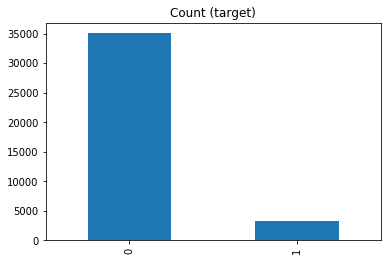

In [9]:
target_count = train['Promoted_or_Not'].value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

In [10]:
train['Trainings_Attended'].value_counts()

2     30981
3      5631
4      1244
5       316
6        93
7        28
8         6
10        5
11        4
9         4
Name: Trainings_Attended, dtype: int64

In [11]:
df = train.drop(columns=['EmployeeNo','State_Of_Origin'], axis =1)

In [12]:
def outlier(df,col= 'Year_of_recruitment'):
  yor_std = df[col].std()
  yor_mean = df[col].mean()
  yor_cutoff = yor_std*3
  yor_lower, yor_upper = yor_mean - yor_cutoff, yor_mean + yor_cutoff
  yor_trimmed = df[(df[col]<yor_upper)&(df[col]>yor_lower)]
  return yor_trimmed

In [13]:
# tes_to_tribe={
#     'ABIA': "IGBO",
#     'ADAMAWA':"HAUSA",
#     'AKWA IBOM':"IGBO",
#     'ANAMBRA':"IGBO",
#     'BAUCHI':"IGBO",
#     'BAYELSA':"IGBO",
#     'BENUE':"HAUSA",
#     'BORNO':"HAUSA",
#     'CROSS RIVER':"IGBO",
#     'DELTA':"IGBO",
#     'EBONYI':"IGBO",
#     'EDO':"IGBO",
#     'EKITI':"YORUBA",
#     'ENUGU':"IGBO",
#     'FCT':"HAUSA",
#     'GOMBE':"HAUSA",
#     'IMO':"IGBO",
#     'JIGAWA':"HAUSA",
#     'KADUNA':"HAUSA",
#     'KANO':'HAUSA',
#     'KATSINA':"HAUSA",
#     'KEBBI':"HAUSA",
#     'KOGI':"HAUSA",
#     'KWARA':"HAUSA",
#     "LAGOS":"YORUBA",
#     'NASSARAWA':"HAUSA",
#     'NIGER':"HAUSA",
#      'OGUN':"YORUBA",
#      'ONDO':"YORUBA",
#      'OSUN':"YORUBA",
#      'OYO':"YORUBA",
#      'PLATEAU':"HAUSA",
#      'RIVERS':"IGBO",
#      'SOKOTO':"HAUSA",
#      'TARABA':"HAUSA",
#      'YOBE':"HAUSA",
#      'ZAMFARA':"HAUSA"

In [14]:
df = outlier(df, col= 'Year_of_recruitment')
# df = outlier(df, col= )

In [15]:
# newvar = df['Trainings_Attended'].value_counts()
# mask = df['Trainings_Attended'].isin(newvar[newvar<100].index)
# df['Trainings_Attended'] [mask] = 'others'

In [16]:
by = df['Promoted_or_Not']

In [17]:
df.describe()

,Trainings_Attended,Year_of_birth,Year_of_recruitment,Training_score_average,Promoted_or_Not
count,37635.000000,37635.000000,37635.000000,37635.000000,37635.000000
mean,2.255055,1986.520818,2013.436482,55.374837,0.084868
std,0.610721,7.326340,3.638399,13.382201,0.278689
min,2.000000,1955.000000,2001.000000,31.000000,0.000000
25%,2.000000,1983.000000,2012.000000,43.000000,0.000000
50%,2.000000,1988.000000,2014.000000,52.000000,0.000000
75%,2.000000,1992.000000,2016.000000,68.000000,0.000000
max,11.000000,2001.000000,2018.000000,91.000000,1.000000


In [18]:
s_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in s_split.split(df, by):
    strat_train_set = df.iloc[train_index]
    strat_test_set = df.iloc[test_index]

In [19]:
def train_val_set(dataset, y):
    y_set = dataset[y].copy()
    X_set = dataset.drop(y,axis=1)
    
    return X_set, y_set

In [20]:
train_feature, train_label = train_val_set(strat_train_set, 'Promoted_or_Not')
val_feature, val_label = train_val_set(strat_test_set, 'Promoted_or_Not')

In [21]:
def num_cat_vals(dataframe):
    num_vals = dataframe.select_dtypes(include=['float64','int64'])
    cat_vals = dataframe.select_dtypes(include='category')
    return cat_vals, num_vals

In [22]:
cat_vals, num_vals = num_cat_vals(train_feature)

In [23]:
Year_of_recruitment_ix, Training_score_average_ix = [
    list(num_vals.columns).index(col)
    for col in ['Year_of_recruitment','Training_score_average']]


class Add_Extra_Features(BaseEstimator, TransformerMixin):
    def __init__(self, name =False):
        self.name = name
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        yor_per_tsa = X.iloc[:, Year_of_recruitment_ix] / X.iloc[:, Training_score_average_ix]
        return np.c_[X, yor_per_tsa]

In [24]:
num_pipeline = Pipeline([
     ('new_attrib', Add_Extra_Features(name =False)),
     ('standard', StandardScaler()),
#      ('poly', PolynomialFeatures(degree=3))
    ])
cat_fill =  Pipeline([
     ('imputer', SimpleImputer(strategy="most_frequent")),
     ('one_hot', OneHotEncoder(sparse=False))
])

In [25]:
num_ = list(num_vals.columns)
cat_one = ['Targets_met','Previous_Award','Previous_IntraDepartmental_Movement','Past_Disciplinary_Action','Foreign_schooled']
cat_two = ['Division','Gender','Marital_Status','Last_performance_score','No_of_previous_employers','Channel_of_Recruitment','Trainings_Attended','Qualification']

full_pipeline = ColumnTransformer([
    ('num_trans', num_pipeline, num_),
    ('cat_label', OrdinalEncoder(), cat_one),
    ('cat_one_hot', cat_fill, cat_two),
])

pipeline_X = full_pipeline.fit_transform(train_feature)

In [26]:
pipeline_v = full_pipeline.transform(val_feature)
pipeline_v.shape

(7527, 53)

In [27]:
pipeline_X.shape

(30108, 53)

In [28]:
pipeline_X

array([[-0.4183091 , -0.48051514, -0.39595474, ...,  0.        ,
         1.        ,  0.        ],
       [-0.4183091 ,  1.1572517 ,  0.15355805, ...,  0.        ,
         0.        ,  1.        ],
       [-0.4183091 , -2.66420426, -2.59400591, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.4183091 ,  0.74780999, -0.12119834, ...,  1.        ,
         0.        ,  0.        ],
       [-0.4183091 ,  1.1572517 ,  0.97782724, ...,  1.        ,
         0.        ,  0.        ],
       [-0.4183091 , -0.88995685, -0.39595474, ...,  1.        ,
         0.        ,  0.        ]])

In [ ]:
model = Pipeline([
        ('sampling', ADASYN(random_state=42)),
        ('classification', XGBClassifier(objective ='binary:hinge', 
                                         silent=False,
                                         scale_pos_weight=1,
                                         learning_rate = 0.01,
                                         subsample = 1.0,
                                         n_estimators=5000, 
                                         max_depth=16, 
                                         booster = 'dart',
                                         colsample_bytree = 0.6,
                                         reg_alpha = 0.28,
                                         gamma=0.4))
                                         ])
                      
model.fit(pipeline_X, train_label)

In [ ]:
y_pred = model.predict(pipeline_X)
model.score(pipeline_X, train_label)

In [ ]:
accuracy = accuracy_score(train_label.astype(int), y_pred.astype(int))
accuracy

In [ ]:
confusion_matrix(train_label, y_pred)

In [ ]:
cl = classification_report(train_label.astype(int), y_pred.astype(int))
print(cl)

In [ ]:
y_v_pred = model.predict(pipeline_v)
y_v_pred

In [ ]:
accuracy = accuracy_score(val_label.astype(int), y_v_pred.astype(int))
accuracy

In [ ]:
confusion_matrix(val_label, y_v_pred)

In [ ]:
f1 = f1_score(val_label.astype(int), y_v_pred.astype(int))
f1

In [ ]:
cl = classification_report(val_label.astype(int), y_v_pred.astype(int))
print(cl)

In [ ]:
pipe_test = full_pipeline.transform(test)
pipe_test.shape

In [ ]:
 test_pred = model.predict(pipe_test)

In [ ]:
df_sub = pd.DataFrame()
df_sub['EmployeeNo']  = test_['EmployeeNo']
df_sub['Promoted_or_Not'] = test_pred
df_sub.head()

In [ ]:
df_sub.to_csv("xgb_11_ho.csv", index=False)